In [574]:
library(jsonlite)
library(magrittr)
library(stringr)
library(tidyverse)

In [606]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Exposure history in trial arms

## Load data

In [575]:
run.folder  <- "/Volumes/Samsung USB/TESTS/exposure-recording-3"
logs        <- file.path(run.folder, "trial-0", "trial_exposure")
config.file <- file.path(run.folder, "configuration", "configuration.json")
file.names  <- dir(logs, pattern = "*.csv")

In [576]:
read.csv <- function(file.name) {
  df <- read_csv(file.path(src, file.name), col_names=FALSE, cols(.default = col_integer()))

  # starting from the third column, the n-th column is frequency of hosts with n cleared colonizations
  # rename columns with integer values to prepare for the gather (unpivot) call
  colnames(df) <- 1:ncol(df) - 3
  
  # unpivot
  df <- gather(df, exposure, count, 3:ncol(df))
  
  # still have to coerce exposure column to number
  df$exposure <- as.numeric(df$exposure)
  
  # rename the first and second columns
  colnames(df)[colnames(df) == -2] <- "dsb" # days since birth (age)
  colnames(df)[colnames(df) == -1] <- "dsv" # days since vaccination
  
  # add a column with the trial arm nae
  df['arm'] <- strsplit(file.name, ".csv")
  df
}

Read CSVs, combine into one data frame, add time varibles (in months), and normalize frequency counts.
- `dsb` : days since birth
- `dsv` : days since vaccination
- `exposure` : number of cleared colonizations
- `count`: number of participants
- `age` : months since birth, i.e. dsb / 30
- `followup` : months since vaccination, i.e. dsv / 30
- `prevalence` : proportion of trial arm with a certain number of cleared colonizations at certain time

In [577]:
data <- file.names %>%
  map(read.csv) %>%
  bind_rows() %>%
  mutate(age = dsb / 30, followup = dsv / 30) %>%
  group_by(arm, dsb) %>%
  mutate(prevalence = count / sum(count)) %>%
  ungroup()

Set order of arms

In [578]:
file.names

[1] "control-infant.csv"   "control-toddler.csv"  "dr-10ce-infant.csv"  
 [4] "dr-10ce-toddler.csv"  "dr-3ce-infant.csv"    "dr-3ce-toddler.csv"  
 [7] "dr-5ce-infant.csv"    "dr-5ce-toddler.csv"   "sr-0.5-infant.csv"   
[10] "sr-1.0-6A-infant.csv" "sr-1.0-infant.csv"

In [579]:
# data %<>%
#   mutate(arm = parse_factor(arm, levels=c(
#     'control-infant',
#     'control-toddler',
#     'dr-3ce-infant',
#     'dr-3ce-toddler',
#     'dr-5ce-infant',
#     'dr-5ce-toddler',
#     'dr-10ce-infant',
#     'dr-10ce-toddler',
#     'sr-0.5-infant',
#     'sr-1.0-6A-infant',
#     'sr-1.0-infant')
#   ))

Add "colonization equivalents"

In [580]:
data %<>%
  mutate(
    # age at vaccination
    infant.vac  = grepl('infant', arm),
    toddler.vac = grepl('toddler', arm),
    
    # potential bonus (in terms of colonization equivalents) if older than age at vaccination
    # bonus may be zero if trial arm is control or does not have the right vaccine
    bonus      = if_else(grepl('ce', arm), as.numeric(str_extract(arm, '[0-9]+')), 0),
    
    # check age requirements and award colonization equivalents 
    ce         = if_else(infant.vac & age >= 2, exposure + bonus, 
                   if_else(toddler.vac & age >= 12, exposure + bonus, exposure))
  ) %>%
  select(-infant.vac, -toddler.vac, -bonus)

Translate colonization equivalents into relative reduction in carriage duration

In [581]:
ep = read_json(config.file)$host$epsilon
get_protection <- function(x) 1.0 - exp(-ep * x)

Generate summary statistics

In [582]:
data.summary <- data %>%
  group_by(arm, age, followup) %>%
  arrange(exposure) %>%
  mutate(
    cdf = cumsum(prevalence)
  ) %>%
  summarise(
    median.exposure = exposure[cdf >= 0.5][[1]],
    mean.exposure   = sum(exposure * prevalence),
    median.ce       = ce[cdf >= 0.5][[1]],
    mean.ce         = sum(ce * prevalence),
    mean.protection = get_protection(mean.ce)
  )

In [655]:
head(filter(data.summary, age == 24, grepl("infant", arm)), 10)

arm,age,followup,median.exposure,mean.exposure,median.ce,mean.ce,mean.protection
control-infant,24,22,16,16.644223,16,16.644223,0.8107000
dr-10ce-infant,24,22,18,18.503822,28,28.503822,0.9421778
dr-3ce-infant,24,22,17,17.679386,20,20.679386,0.8735538
dr-5ce-infant,24,22,18,18.081036,23,23.081036,0.9005503
sr-0.5-infant,24,22,9,9.656934,9,9.656934,0.6192809
sr-1.0-6A-infant,24,22,15,14.756198,15,14.756198,0.7713630
sr-1.0-infant,24,22,1,1.567427,1,1.567427,0.1450760


## Plot

In [584]:
my.theme <- theme_classic() + 
  theme(panel.grid.major = element_line(colour = "grey80", linetype = "dotted"))

Reminder of the arm names

In [585]:
unlist(strsplit(file.names, '.csv'))

[1] "control-infant"   "control-toddler"  "dr-10ce-infant"   "dr-10ce-toddler" 
 [5] "dr-3ce-infant"    "dr-3ce-toddler"   "dr-5ce-infant"    "dr-5ce-toddler"  
 [9] "sr-0.5-infant"    "sr-1.0-6A-infant" "sr-1.0-infant"

See distribution of exposures

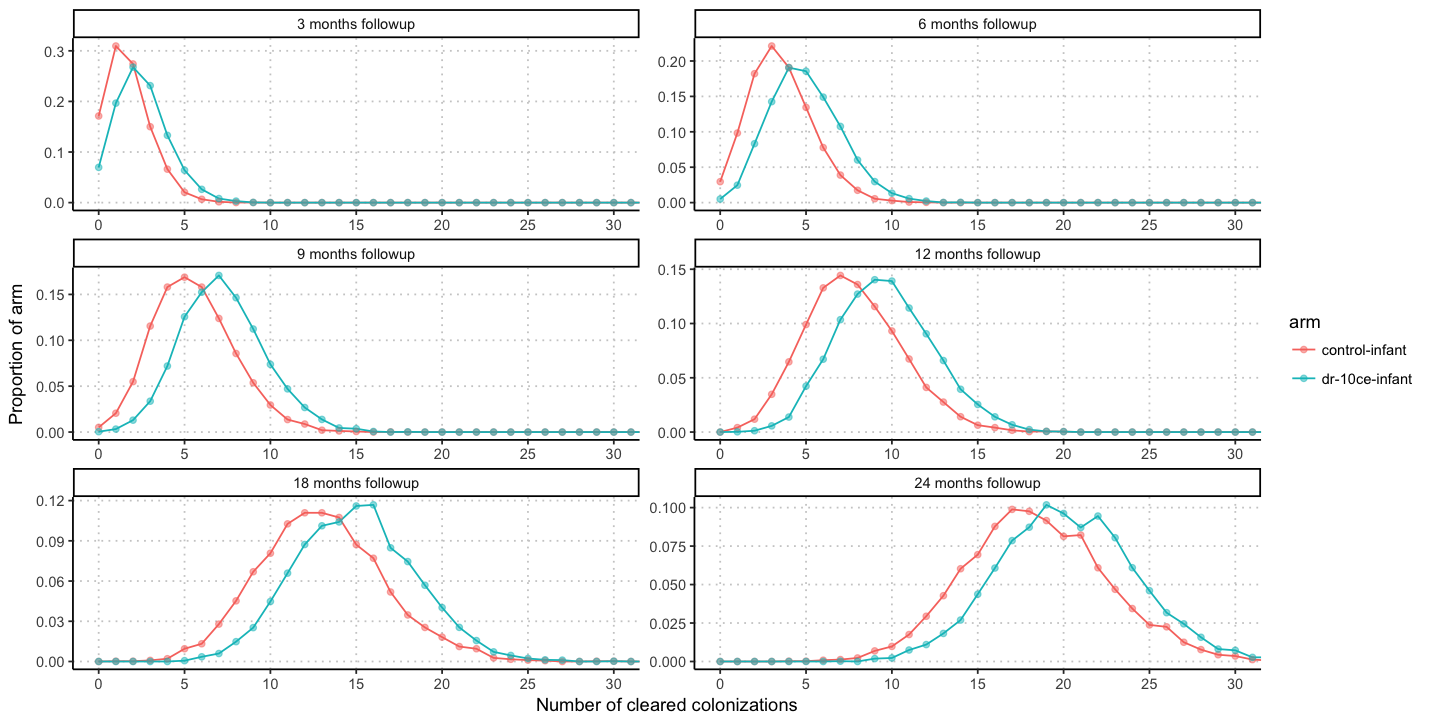

In [650]:
options(repr.plot.width=12, repr.plot.height=6)

visits <- c(3, 6, 9, 12, 18, 24)
arms <- c('control-infant', 'dr-10ce-infant')

ggplot(filter(data, arm %in% arms, followup %in% visits), aes(x = exposure, y = prevalence)) +
  geom_line(aes(group = arm, color = arm), alpha = 1) +
  geom_point(aes(group = arm, color = arm), alpha = 0.5) +
  coord_cartesian(xlim=c(0, 30)) + 
  scale_x_continuous(breaks=seq(0, 30, 5), name="Number of cleared colonizations") + 
  scale_y_continuous(name = "Proportion of arm") + 
  facet_wrap(~followup, ncol=2, scales = 'free', labeller=labeller(followup = function(x) paste(x, "months followup"))) + 
  my.theme

Plot summary stats

In [671]:
plot.var <- function(variable, label, age.group, xlim, ylim, legend=FALSE) {

  arms <- lapply(c('control-', 'dr-3ce-', 'dr-5ce-', 'dr-10ce-'), paste0, age.group)

  g <- ggplot(filter(data.summary, arm %in% arms), aes(x = age, y = get(variable))) + 
    geom_line(aes(group = arm, color = arm), alpha = 0.7) +
    geom_point(aes(group = arm, color = arm), alpha = 0.7) +
    coord_cartesian(xlim=xlim, ylim=ylim) +
    scale_y_continuous(breaks=seq(0, 50, 5), name=label) + 
    scale_x_continuous(breaks=seq(0, 36, 3), name="Age (months)") + 
    scale_color_manual(values=c("black", "steelblue2", "slateblue4", "seagreen3")) +
    my.theme 
  
  if (!legend) { 
    g <- g +  theme(legend.position="none")
  }
  
  g
}

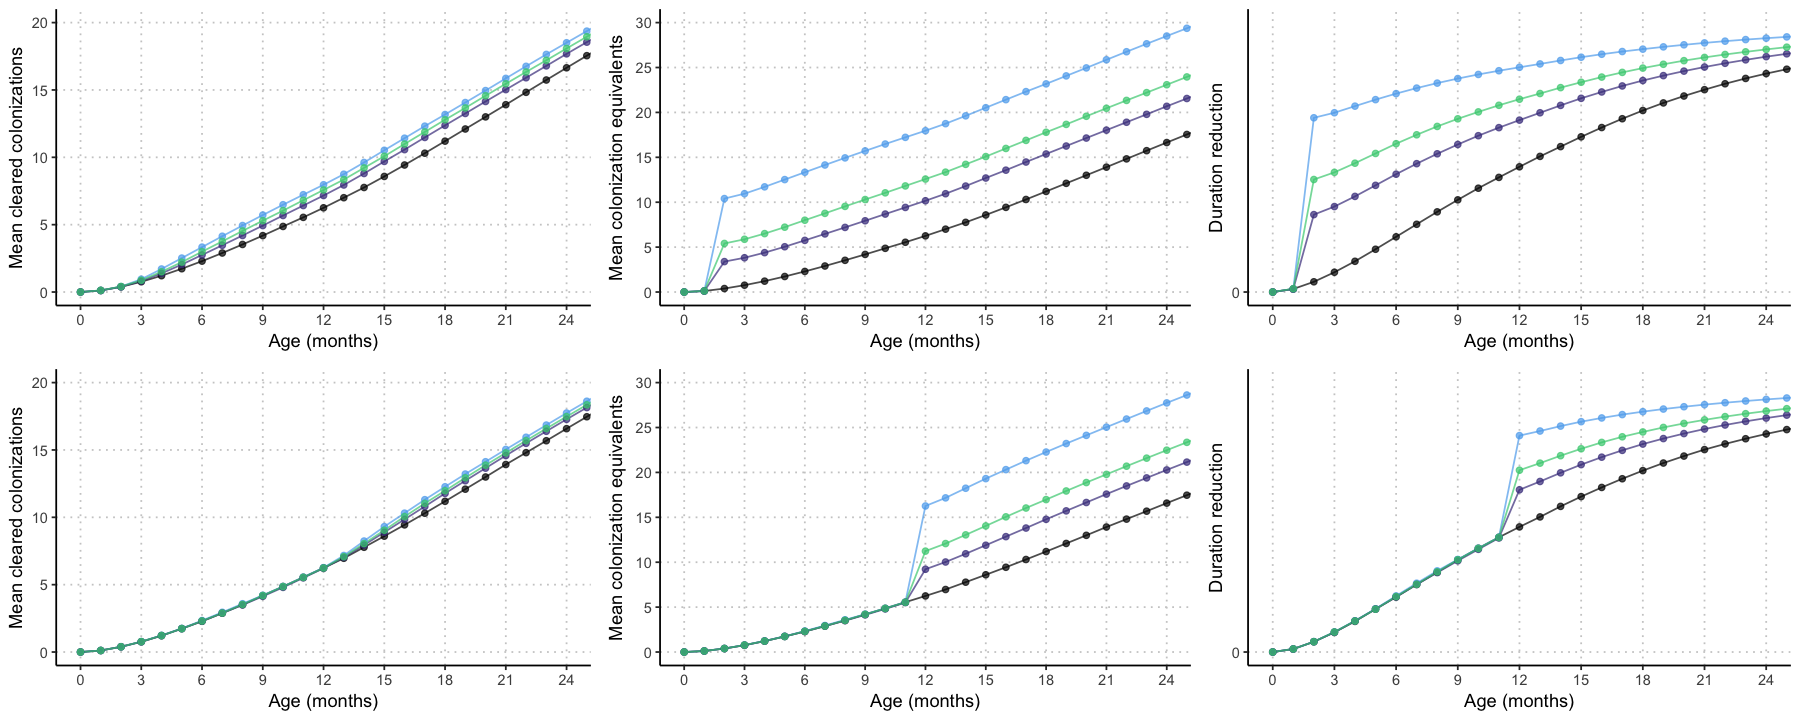

In [675]:
options(repr.plot.width=15, repr.plot.height=6)

multiplot(
  plot.var("mean.exposure",   "Mean cleared colonizations",    "infant",  c(0, 24), c(0, 20)), 
  plot.var("mean.exposure",   "Mean cleared colonizations",    "toddler", c(0, 24), c(0, 20)), 
  plot.var("mean.ce",         "Mean colonization equivalents", "infant",  c(0, 24), c(0, 30)), 
  plot.var("mean.ce",         "Mean colonization equivalents", "toddler", c(0, 24), c(0, 30)), 
  plot.var("mean.protection", "Duration reduction",            "infant",  c(0, 24), c(0, 1)),
  plot.var("mean.protection", "Duration reduction",            "toddler", c(0, 24), c(0, 1)),
  cols=3
)